In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/PhDResearch/ATRAF'

/content/drive/MyDrive/PhDResearch/ATRAF


## Training Transformer

In [3]:
import copy
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.modules.normalization import LayerNorm

# Autoencoder
class Encoder(nn.Module):
    def __init__(self, in_seq_len, out_seq_len, d_model, dropout=0.1):
        super().__init__()
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.d_model = d_model
        self.input_dims = self.in_seq_len * self.d_model
        self.output_dims = self.out_seq_len * self.d_model
        self.dims_1 = (self.input_dims - self.output_dims) // 4 * 3
        self.dims_2 = (self.input_dims - self.output_dims) // 4 * 2

        linear1 = nn.Linear(self.input_dims, self.dims_1)
        linear2 = nn.Linear(self.dims_1, self.dims_2)
        linear3 = nn.Linear(self.dims_2, self.output_dims)

        self.flatten = nn.Flatten()
        self.linears = nn.ModuleList([linear1, linear2, linear3])
        self.dropout = dropout
        self.unflatten = nn.Unflatten(1, (self.out_seq_len, self.d_model))

    def forward(self, x):
        x = self.flatten(x)
        for i, l in enumerate(self.linears):
            x = F.relu(l(x))
            x = nn.Dropout(p=self.dropout)(x)
        x = self.unflatten(x)
        return x


class Decoder(nn.Module):
    def __init__(self, in_seq_len, out_seq_len, d_model, dropout=0.1):
        super().__init__()
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.d_model = d_model
        self.input_dims = self.in_seq_len * self.d_model
        self.output_dims =  self.out_seq_len * self.d_model
        self.dims_1 = (self.input_dims - self.output_dims) // 4 * 3
        self.dims_2 = (self.input_dims - self.output_dims) // 4 * 2

        linear1 = nn.Linear(self.output_dims, self.dims_2)
        linear2 = nn.Linear(self.dims_2, self.dims_1)
        linear3 = nn.Linear(self.dims_1, self.input_dims)

        self.linears = nn.ModuleList([linear1, linear2, linear3])
        self.dropout = dropout
        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(1, (self.in_seq_len, self.d_model))

    def forward(self, x):
        x = self.flatten(x)
        for i, l in enumerate(self.linears):
            x = F.relu(l(x))
            x = nn.Dropout(p=self.dropout)(x)
        x = self.unflatten(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input):
        output = self.decoder(self.encoder(input))
        return output

def make_autoencoder_model(in_seq_len, out_seq_len, d_model, dropout=0.1):
    encoder = Encoder(in_seq_len, out_seq_len, d_model, dropout)
    decoder = Decoder(in_seq_len, out_seq_len, d_model, dropout)
    model = Autoencoder(encoder, decoder)
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model




In [4]:
""" This code is a slightly modified version of The Annotated Transformer."""

class TransformerModel(nn.Module):
    def __init__(self, encoder, src_embed, linear):
        super().__init__()
        self.encoder = encoder
        self.src_embed = src_embed
        self.linear = linear

    def forward(self, src, src_mask):
        output = F.relu(self.linear(
            self.encoder(self.src_embed(src), src_mask)))
        return output


def clones(module, N):
    """
    Produce N identical layers
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class TransformerEncoder(nn.Module):
    "Core encoder is a stack of N layers"

    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn"
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super().__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """
        Apply residual connection to any sublayer with the same size.
        """
        return x + self.dropout(sublayer(self.norm(x)))


class TransformerEncoderLayer(nn.Module):
    """
    Encoder is made up of self-attn and feed foward
    """

    def __init__(self, size, self_attn, feed_forward, dropout):
        super().__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)


def attention(query, key, value, mask=None, dropout=0.0):
    """Compute the Scaled Dot-Product Attention"""
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    p_attn = F.dropout(p_attn, p=dropout)
    return torch.matmul(p_attn, value), p_attn


class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        """
        Take in model size and number of heads.
        """
        super().__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.p = dropout
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]
        # 2) Apply attention on all the projected vectors in batch
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.p)
        # 3) "Concat" using a view and apply a final linear
        x = x.transpose(1, 2).contiguous().view(
            nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)


class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        # Torch linears have a "b" by default.
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


class PositionalEncoding(nn.Module):
    """ Implement the PE function. """

    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2)
                             * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(div_term * position)
        pe[:, 1::2] = torch.cos(div_term * position)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1), :], requires_grad=False)
        return self.dropout(x)

class FNetEncoderLayer(nn.Module):
    """
    Encoder is made up of a Fourier Mixing Layer and a FF Layer
    """

    def __init__(self, size, fft, feed_forward, dropout):
        super().__init__()
        self.fft = fft
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x):
        x = self.sublayer[0](x, lambda x: self.fft(x, x, x))
        return self.sublayer[1](x, self.feed_forward)


class FourierFFTLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, query, key, value):
        assert query is key
        assert key is value

        x = query
        return torch.real(torch.fft.fft(torch.fft.fft(x, dim=-1), dim=-2))


class FNetHybridModel(nn.Module):
    def __init__(self, trans, src_embed, linear, fnet):
        super().__init__()
        self.trans = trans
        self.src_embed = src_embed
        self.linear = linear
        self.fnet = fnet

    def forward(self, src, src_mask):
        output = F.relu(self.linear(self.fnet(
            self.trans(self.src_embed(src), src_mask))))
        return output


class FNetEncoder(nn.Module):
    "Core Fnet is a stack of N layers"

    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x):
        "Pass the input through each layer in turn"
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)



class FNetEncoderLayer(nn.Module):
    """
    Encoder is made up of a Fourier Mixing Layer and a FF Layer
    """

    def __init__(self, size, fft, feed_forward, dropout):
        super().__init__()
        self.fft = fft
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x):
        x = self.sublayer[0](x, lambda x: self.fft(x, x, x))
        return self.sublayer[1](x, self.feed_forward)


class FourierFFTLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, query, key, value):
        assert query is key
        assert key is value

        x = query
        return torch.real(torch.fft.fft(torch.fft.fft(x, dim=-1), dim=-2))

def make_transformer_model(N, d_model, l_win, d_ff=0, h=8, dropout=0.1):
    if (d_ff == 0):
        d_ff = d_model * 4
    c = copy.deepcopy
    attn = MultiHeadAttention(h, d_model, dropout)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout, l_win)
    final_linear = nn.Linear(d_model, d_model)
    model = TransformerModel(
        TransformerEncoder(TransformerEncoderLayer(
            d_model, c(attn), c(ff), dropout), N),
        nn.Sequential(position),
        final_linear
    )

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

def create_fnet_hybrid(N, d_model, l_win, d_ff=0, h=8, dropout=0.1):
    if (d_ff == 0):
        d_ff = d_model * 4
    c = copy.deepcopy
    attn = MultiHeadAttention(h, d_model, dropout)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout, l_win)
    final_linear = nn.Linear(d_model, d_model)
    fft = FourierFFTLayer()
    model = FNetHybridModel(
        TransformerEncoder(TransformerEncoderLayer(
            d_model, c(attn), c(ff), dropout), 1),
        nn.Sequential(position),
        final_linear,
        FNetEncoder(FNetEncoderLayer(d_model, c(fft), c(ff), dropout), N - 1)
    )

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model





In [5]:
import argparse
import json
import os


def get_config_from_json(json_file):
    """
    Get the config from a json file
    :param: json_file
    :return: config(dictionary)
    """
    # parse the configurations from the config json file provided
    with open(json_file, "r") as config_file:
        config_dict = json.load(config_file)
        config_file.close()
    return config_dict


def save_config(config):
    filename = config["result_dir"] + config["auto_dataset"] + "/" + \
        "training_config_l_win_{}_auto_dims_{}.json".format(
            config["l_win"], config["autoencoder_dims"])
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(config, f, indent=4)

def process_config(json_file):
    config = get_config_from_json(json_file)

    # create directories to save experiment results and trained models
    if config["load_dir"] == "default":
        save_dir = "../experiments/{}/{}/{}".format("Transformer",
            config["experiment"], config["auto_dataset"])
    else:
        save_dir = config["load_dir"]
    config["summary_dir"] = os.path.join(save_dir, "summary/")
    config["result_dir"] = os.path.join(save_dir, "result/")
    config["checkpoint_dir"] = os.path.join(
        save_dir, "checkpoints/")
    return config


def create_dirs(*dirs):
    """
    dirs - a list of directories to create if these directories are not found
    :param dirs:
    :return exit_code: 0:success -1:failed
    """
    try:
        for dir_ in dirs:
            if not os.path.exists(dir_):
                os.makedirs(dir_)
        return 0
    except Exception as err:
        print("Creating directories error: {0}".format(err))
        exit(-1)


def get_args():
    argparser = argparse.ArgumentParser(description=__doc__)
    argparser.add_argument(
        "-c", "--config",
        metavar="C",
        default="None",
        help="The Configuration file")
    # argparser.add_argument(
    #     "-n", "--num-client",
    #     default=1,
    #     help="The number of clients participating in Federated Learning")
    args = argparser.parse_args()
    return args


In [6]:
import numpy as np
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, config, train=True, model_type="autoencoder"):
        super().__init__()
        self.config = config
        self.train = train
        self.model_type = model_type
        if model_type == "autoencoder":
            self.load_dataset(self.config["auto_dataset"])
        else:
            self.load_dataset(self.config["trans_dataset"])

    def __len__(self):
        return self.rolling_windows.shape[0]

    def __getitem__(self, index):
        if (self.train) or (self.model_type == "autoencoder"):
            inp = target = self.rolling_windows[index, :, :]
        else:
            inp = self.rolling_windows[index, :, :]
            target = self.rolling_windows[index,
                                          self.config["pre_mask"]:self.config["post_mask"], :]
        sample = {"input": inp, "target": target}
        return sample

    def load_dataset(self, dataset):
        data_dir = self.config["data_dir"]
        # data_dir = "../data/{}/".format(self.config["data_dir"])
        self.data = np.load(data_dir + dataset + ".npz")

        # slice training set into rolling windows
        if self.model_type == "autoencoder":
            if self.train:
                self.rolling_windows = np.lib.stride_tricks.sliding_window_view(
                    self.data["training"], self.config["autoencoder_dims"], axis=0, writeable=True
                ).transpose(0, 2, 1)
            else:
                self.rolling_windows = np.lib.stride_tricks.sliding_window_view(
                    self.data["test"], self.config["autoencoder_dims"], axis=0, writeable=True
                ).transpose(0, 2, 1)
        else:
            if self.train:
                self.rolling_windows = np.lib.stride_tricks.sliding_window_view(
                    self.data["training"], self.config["l_win"], axis=0, writeable=True
                ).transpose(0, 2, 1)
            else:
                self.rolling_windows = np.lib.stride_tricks.sliding_window_view(
                    self.data["test"], self.config["l_win"], axis=0, writeable=True
                ).transpose(0, 2, 1)


In [7]:
import time

import torch
from torch.utils.data.dataloader import DataLoader


device = torch.device("cuda")
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def create_dataloader(dataset, config):
    return DataLoader(dataset,
                      batch_size=config["batch_size"],
                      shuffle=bool(config["shuffle"]),
                      num_workers=config["dataloader_num_workers"])


def loss_backprop(criterion, out, targets):
    assert out.size(1) == targets.size(1)
    loss = criterion(out, targets)
    loss.backward()
    return loss


def create_mask(config):
    mask = torch.ones(1, config["l_win"], config["l_win"])
    mask[:, config["pre_mask"]:config["post_mask"], :] = 0
    mask[:, :, config["pre_mask"]:config["post_mask"]] = 0
    mask = mask.float().masked_fill(mask == 0, float(
        "-inf")).masked_fill(mask == 1, float(0))
    return mask


min_trans_loss = float("inf")
best_trans_model = None
epoch_trans_loss = list()

def trans_train_epoch(train_iter, model, autoencoder, criterion, mask, opt, epoch, config):
    global min_trans_loss, best_trans_model, epoch_trans_loss
    model.train()
    model.to(device)
    autoencoder.eval()
    encoder = autoencoder.encoder
    encoder.to(device)
    batch_loss = list()
    for i, batch in enumerate(train_iter):
        src = batch["input"].float()
        # src.to('cuda')
        src = encoder(src.cuda())
        trg = batch["target"].float()
        # trg.to('cuda')
        trg = encoder(trg.cuda())
        # trg.to(device)
        out = model(src.cuda(), src_mask=mask.cuda())

        opt.zero_grad()
        out.is_cuda
        trg.is_cuda
        loss = loss_backprop(criterion, out, trg)
        opt.step()
        batch_loss.append(loss.item())

    if len(batch_loss) > 0:
        epoch_trans_loss.append(sum(batch_loss)/len(batch_loss))
        print('TRANSFORMER. Epoch: {} \tTotal Loss: {:.6f}'.format(epoch,
                                                                          epoch_trans_loss[-1]))

    if epoch_trans_loss[-1] < min_trans_loss:
        torch.save(model.state_dict(),
                   config["checkpoint_dir"] + config["auto_dataset"] + "/" + f"best_trans_{epoch}.pth")
        torch.save(opt.state_dict(),
                   config["checkpoint_dir"] + config["auto_dataset"] + "/" + f"optimizer_trans_{epoch}.pth")
        min_trans_loss = epoch_trans_loss[-1]
        best_trans_model = f"best_trans_{epoch}.pth"
    if best_trans_model != None:
        return best_trans_model


min_auto_loss = float("inf")
best_auto_model = None
epoch_auto_loss = list()

def autoencoder_train_epoch(train_iter, model, criterion, opt, epoch, config):
    global min_auto_loss, best_auto_model, epoch_auto_loss
    model.train()
    model.to(device)
    batch_loss = list()
    for i, batch in enumerate(train_iter):
        src = batch["input"].float()
        src.to(device)
        trg = batch["target"].float()
        trg.to(device)
        out = model(src.cuda())
        # out = model(src)
        opt.zero_grad()
        loss = loss_backprop(criterion, out, trg.cuda())
        opt.step()
        batch_loss.append(loss.item())

    if len(batch_loss) > 0:
        epoch_auto_loss.append(sum(batch_loss)/len(batch_loss))
        print('AUTOENCODER. Epoch: {} \tTotal Loss: {:.6f}'.format(epoch, epoch_auto_loss[-1]))

    if epoch_auto_loss[-1] < min_auto_loss:
        torch.save(model.state_dict(),
                   config["checkpoint_dir"] + config["auto_dataset"] + "/" + f"best_autoencoder_{epoch}.pth")
        torch.save(opt.state_dict(),
                   config["checkpoint_dir"] + config["auto_dataset"] + "/" + f"optimizer_autoencoder_{epoch}.pth")
        min_auto_loss = epoch_auto_loss[-1]
        best_auto_model = f"best_autoencoder_{epoch}.pth"
    if best_auto_model != None:
        return best_auto_model

In [8]:
config = {
    "experiment": "GasPipeline",
    "data_dir": "/content/drive/MyDrive/PhDResearch/ATRAF/Anomaly-Detection-with-Transformer-Encoder/dataset/",
    "auto_dataset": "scada1",
    "trans_dataset": "scada1",
    "num_stacks": 1,
    "d_model": 16,
    "d_ff": 128,
    "num_heads": 1,
    "dropout": 0.1,
    "autoencoder_dims": 100,
    "l_win": 25,
    "pre_mask": 10,
    "post_mask": 15,
    "batch_size": 64,
    "shuffle": 1,
    "dataloader_num_workers": 2,
    "auto_num_epoch": 15,
    "trans_num_epoch": 20,
    "load_dir": "default",
    "checkpoint_dir": "/content/drive/MyDrive/PhDResearch/ATRAF/Anomaly-Detection-with-Transformer-Encoder/experiments/",
    "result_dir": "/content/drive/MyDrive/PhDResearch/ATRAF/Anomaly-Detection-with-Transformer-Encoder/result/",
}

In [9]:
result_dir = config["result_dir"] + config["auto_dataset"] + "/"
checkpoint_dir = config["checkpoint_dir"] + config["auto_dataset"] + "/"

create_dirs(result_dir, checkpoint_dir)
# create_dirs(config["result_dir"], config["checkpoint_dir"])

dataset = CustomDataset(config)
dataloader = create_dataloader(dataset, config)

In [12]:
result_dir = config["result_dir"] + config["auto_dataset"] + "/"
checkpoint_dir = config["checkpoint_dir"] + config["auto_dataset"] + "/"

create_dirs(result_dir, checkpoint_dir)
# create_dirs(config["result_dir"], config["checkpoint_dir"])

dataset = CustomDataset(config)
dataloader = create_dataloader(dataset, config)

# Training the autoencoder
start = time.time()
autoencoder_model = make_autoencoder_model(in_seq_len=config["autoencoder_dims"],
                                            out_seq_len=config["l_win"],
                                            d_model=config["d_model"])
autoencoder_model.float()
model_opt = torch.optim.Adam(autoencoder_model.parameters())
criterion = torch.nn.MSELoss()
for epoch in range(config["auto_num_epoch"]):
    config["best_auto_model"] = autoencoder_train_epoch(dataloader,
                                                        autoencoder_model,
                                                        criterion,
                                                        model_opt,
                                                        epoch,
                                                        config)
print("COMPLETED TRAINING THE AUTOENCODER")
config["auto_train_time"] = (time.time() - start) / 60

# Training the transformer model
start = time.time()
mask = create_mask(config)
# trans_model = make_transformer_model(N=config["num_stacks"],
#                                       d_model=config["d_model"],
#                                       l_win=config["l_win"],
#                                       d_ff=config["d_ff"],
#                                       h=config["num_heads"],
#                                       dropout=config["dropout"])

trans_model = create_fnet_hybrid(N=config["num_stacks"],
                                  d_model=config["d_model"],
                                  l_win=config["l_win"],
                                  d_ff=config["d_ff"],
                                  h=config["num_heads"],
                                  dropout=config["dropout"])

trans_model.float()
model_opt = torch.optim.Adam(trans_model.parameters())
autoencoder_model.load_state_dict(
    torch.load(config["checkpoint_dir"] + config["auto_dataset"] + "/" + config["best_auto_model"]))
for epoch in range(config["trans_num_epoch"]):
    config["best_trans_model"] = trans_train_epoch(dataloader,
                                                    trans_model,
                                                    autoencoder_model,
                                                    criterion,
                                                    mask,
                                                    model_opt,
                                                    epoch,
                                                    config)
print("COMPLETED TRAINING THE TRANSFORMER")
config["trans_train_time"] = (time.time() - start) / 60
save_config(config)


AUTOENCODER. Epoch: 0 	Total Loss: 0.496696
AUTOENCODER. Epoch: 1 	Total Loss: 0.471486
AUTOENCODER. Epoch: 2 	Total Loss: 0.464774
AUTOENCODER. Epoch: 3 	Total Loss: 0.462668
AUTOENCODER. Epoch: 4 	Total Loss: 0.461039
AUTOENCODER. Epoch: 5 	Total Loss: 0.460479
AUTOENCODER. Epoch: 6 	Total Loss: 0.459989
AUTOENCODER. Epoch: 7 	Total Loss: 0.459853
AUTOENCODER. Epoch: 8 	Total Loss: 0.460516
AUTOENCODER. Epoch: 9 	Total Loss: 0.460228
AUTOENCODER. Epoch: 10 	Total Loss: 0.460520
AUTOENCODER. Epoch: 11 	Total Loss: 0.460405
AUTOENCODER. Epoch: 12 	Total Loss: 0.461122
AUTOENCODER. Epoch: 13 	Total Loss: 0.461734
AUTOENCODER. Epoch: 14 	Total Loss: 0.461844
COMPLETED TRAINING THE AUTOENCODER
TRANSFORMER. Epoch: 0 	Total Loss: 14.052588
TRANSFORMER. Epoch: 1 	Total Loss: 11.580876
TRANSFORMER. Epoch: 2 	Total Loss: 11.334093
TRANSFORMER. Epoch: 3 	Total Loss: 11.184918
TRANSFORMER. Epoch: 4 	Total Loss: 11.074692
TRANSFORMER. Epoch: 5 	Total Loss: 10.999404
TRANSFORMER. Epoch: 6 	Total L

# **Testing**

In [13]:
import math
import time
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import norm
from sklearn import metrics

def load_model(config):
    autoencoder_model = make_autoencoder_model(in_seq_len=config["autoencoder_dims"],
                                               out_seq_len=config["l_win"],
                                               d_model=config["d_model"])
    autoencoder_model.load_state_dict(torch.load(
        config["checkpoint_dir"] + config["auto_dataset"] + "/" +  config["best_auto_model"]))
    autoencoder_model.float()
    autoencoder_model.eval()

    # trans_model = make_transformer_model(N=config["num_stacks"],
    #                                      d_model=config["d_model"],
    #                                      l_win=config["l_win"],
    #                                      d_ff=config["d_ff"],
    #                                      h=config["num_heads"],
    #                                      dropout=config["dropout"])

    trans_model = create_fnet_hybrid(N=config["num_stacks"],
                                  d_model=config["d_model"],
                                  l_win=config["l_win"],
                                  d_ff=config["d_ff"],
                                  h=config["num_heads"],
                                  dropout=config["dropout"])

    trans_model.load_state_dict(torch.load(
        config["checkpoint_dir"] + config["auto_dataset"] + "/" + config["best_trans_model"]))
    trans_model.float()
    trans_model.eval()

    return autoencoder_model.encoder, trans_model


def create_labels(idx_anomaly_test, n_test, config):
    anomaly_index = []
    test_labels = np.zeros(n_test)
    for i in range(len(idx_anomaly_test)):
        idx_start = idx_anomaly_test[i] - (config["l_win"] + 1)
        idx_end = idx_anomaly_test[i] + (config["l_win"] + 1)
        if idx_start < 0:
            idx_start = 0
        if idx_end > n_test:
            idx_end = n_test
        anomaly_index.append(np.arange(idx_start, idx_end))
        test_labels[idx_start:idx_end] = 1
    return anomaly_index, test_labels


def return_anomaly_idx_by_threshold(test_anomaly_metric, threshold):
    # test_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    idx_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold))

    if len(idx_error.shape) == 0:
        idx_error = np.expand_dims(idx_error, 0)

    return list(idx_error)


def augment_detected_idx(idx_detected_anomaly, anomaly_index):
    n_anomaly = len(anomaly_index)
    idx_detected_anomaly_extended = list(idx_detected_anomaly)
    for i in range(n_anomaly):
        # print(idx_detected_anomaly)
        for j in idx_detected_anomaly:
            if j in anomaly_index[i]:
                in_original_detection = set(idx_detected_anomaly_extended)
                currect_anomaly_win = set(anomaly_index[i])
                idx_detected_anomaly_extended = idx_detected_anomaly_extended + \
                    list(currect_anomaly_win - in_original_detection)
                # print(j)
                break
    return list(np.sort(idx_detected_anomaly_extended))


def count_TP_FP_FN(idx_detected_anomaly, test_labels):
    n_TP = 0
    n_FP = 0
    #n_detection = len(idx_detected_anomaly)
    # for i in range(n_detection):
    for i in idx_detected_anomaly:
        # if test_labels[idx_detected_anomaly[i]] == 1:
        if test_labels[i] == 1:
            n_TP = n_TP + 1
        else:
            n_FP = n_FP + 1

    idx_undetected = list(set(np.arange(len(test_labels))
                              ) - set(idx_detected_anomaly))
    n_FN = 0
    for i in idx_undetected:
        if test_labels[i] == 1:
            n_FN = n_FN + 1
    n_TN = len(test_labels) - n_TP - n_FP - n_FN
    return n_TP, n_FP, n_FN, n_TN


def compute_precision_and_recall(idx_detected_anomaly, test_labels):
    # compute true positive
    n_TP, n_FP, n_FN, n_TN = count_TP_FP_FN(idx_detected_anomaly, test_labels)

    if n_TP + n_FP == 0:
        precision = 1
    else:
        precision = n_TP / (n_TP + n_FP)
    recall = n_TP / (n_TP + n_FN)
    if precision + recall == 0:
        F1 = 0
    else:
        F1 = 2 * (precision * recall)/(precision + recall)
    fpr = n_FP/(n_FP + n_TN)

    return precision, recall, F1, fpr, n_TP, n_FP, n_FN


def KQp(data, q):
    data2 = np.sort(data)  # sap xep tang dan
    n = np.shape(data2)[0]  # kich thuoc
    p = 1-q  # q tu xet, dat bang smth 0.05 0.025 0.01
    h = math.sqrt((p*q)/(n+1))
    KQ = 0
    for i in range(1, n+1):
        a = ((i/n)-p)/h
        b = (((i-1)/n)-p)/h
        TP = (norm.cdf(a)-norm.cdf(b))*data2[i-1]  # normcdf thu trong matlab
        KQ = KQ+TP
    # KQp = KQ;
    return KQ


def plot_roc_curve(fpr_aug, recall_aug, config, n_threshold=20):
    tpr = np.insert(recall_aug, [0, n_threshold], [0, 1])
    fpr = np.insert(fpr_aug, [0, n_threshold], [0, 1])
    auc = metrics.auc(fpr, tpr)
    print("AUC =", auc)
    lw = 2
    plt.plot(fpr, tpr, color="darkorange", lw=lw,
             label="ROC curve (area = %0.4f)" % auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Augmented Receiver operating characteristic of " +
              config["auto_dataset"])
    plt.legend(loc="lower right")
    plt.savefig(config["result_dir"] + config["auto_dataset"] + "/" + "augmentedroc.pdf")
    return auc


def select_threshold(recon_loss, anomaly_index, test_labels, config, n_threshold=20):
    """
    Select best threshold based on best F1-score
    """
    precision_aug = np.zeros(n_threshold)
    recall_aug = np.zeros(n_threshold)
    F1_aug = np.zeros(n_threshold)
    fpr_aug = np.zeros(n_threshold)
    i = 0
    threshold_list = np.linspace(np.amin(recon_loss), np.amax(
        recon_loss), n_threshold, endpoint=False)
    threshold_list = np.flip(threshold_list)

    for threshold in threshold_list:
        # print(threshold_list[i])
        idx_detection = return_anomaly_idx_by_threshold(recon_loss, threshold)
        # augment the detection using the ground truth labels
        # a method to discount the factor one anomaly appears in multiple consecutive windows
        # introduced in "Unsupervised anomaly detection via variational auto-encoder for seasonal kpis in web applications"
        idx_detection_augmented = augment_detected_idx(
            idx_detection, anomaly_index)
        precision_aug[i], recall_aug[i], F1_aug[i], fpr_aug[i], _, _, _ = compute_precision_and_recall(idx_detection_augmented,
                                                                                                       test_labels)
        i = i + 1
        # print(precision, recall, F1)

    auc = plot_roc_curve(fpr_aug, recall_aug, config)

    print("\nAugmented detection:")
    print("Best F1 score is {}".format(np.amax(F1_aug)))
    idx_best_threshold = np.squeeze(np.argwhere(F1_aug == np.amax(F1_aug)))
    print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
    best_thres = np.min(threshold_list[idx_best_threshold])
    print("At this threshold, precision is {}, recall is {}".format(precision_aug[idx_best_threshold],
                                                                    recall_aug[idx_best_threshold]))
    return best_thres, auc


def select_KQp_threshold(threshold, recon_loss):
    q_list = [0.99, 0.9, 0.1]
    temp = math.inf
    q_best = 0
    for q in q_list:
        temp_thres = KQp(recon_loss, q)
        # print(temp_thres,abs(temp_thres - threshold))
        if abs(temp_thres - threshold) < temp:
            temp = abs(temp_thres - threshold)
            q_best = q
            KQp_thres = temp_thres
    print("Closest KQp threshold is {} at q = {}".format(KQp_thres, q_best))
    return KQp_thres, q_best


AUC = 0.6185134994028393

Augmented detection:
Best F1 score is 0.7749405857441524
Best threshold is 0.03277943283319473
At this threshold, precision is 0.6325738790513142, recall is 1.0
Closest KQp threshold is 0.5089991254158132 at q = 0.99

PR evaluation using KQE:
Precision: 0.634926212227688
Recall: 1.0
F1: 0.7767032022351171
TP: 43368
FP: 24936
FN: 0


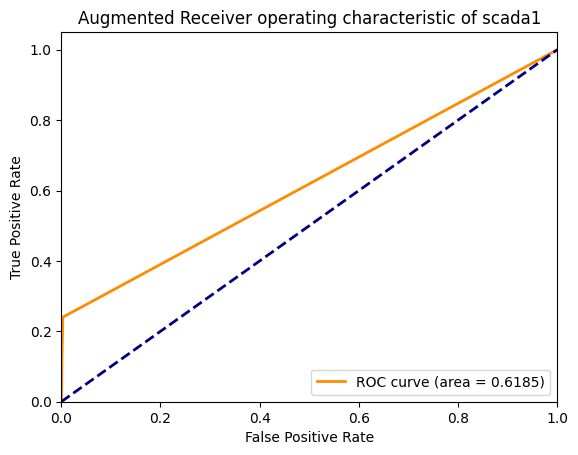

In [14]:
# Using Transformer-Fourier

testing_config_path = '/content/drive/MyDrive/PhDResearch/ATRAF/Anomaly-Detection-with-Transformer-Encoder/result'

dataset = CustomDataset(config, train=False)
data_loader = create_dataloader(dataset, config)
encoder, trans_model = load_model(config)
mask = create_mask(config)
loss = torch.nn.MSELoss()
n_test = len(dataset)
recon_loss = np.zeros(n_test)

start = time.time()
for i, batch in enumerate(data_loader):
    src = encoder(batch["input"].float())
    trg = encoder(batch["target"].float())
    out = trans_model(src, src_mask=mask)
    for j in range(config["batch_size"]):
        try:
            recon_loss[i * config["batch_size"] + j] = loss(
                out[j, config["pre_mask"]:config["post_mask"], :], trg[j, config["pre_mask"]:config["post_mask"], :])
        except:
            pass

idx_anomaly_test = dataset.data["idx_anomaly_test"]
anomaly_index, test_labels = create_labels(idx_anomaly_test,
                                            n_test,
                                            config)

# Now select a threshold
threshold, auc = select_threshold(recon_loss,
                                  anomaly_index,
                                  test_labels,
                                  config)
config["AUC"] = auc

KQp_thres, q_best = select_KQp_threshold(threshold, recon_loss)
config["q_best"] = q_best
idx_detection = return_anomaly_idx_by_threshold(recon_loss, KQp_thres)
# print(idx_detection)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index)
# print(anomaly_index_lstm)
# print(idx_detection_augmented)
precision, recall, F1, _, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented,
                                                                          test_labels)
config["precision"] = precision
config["recall"] = recall
config["F1"] = F1
config["inference_time"] = (time.time() - start) / 60
save_config(config)
print("\nPR evaluation using KQE:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))